<a href="https://colab.research.google.com/github/sweetyjunnarkar/News_topic_modeling/blob/main/Topic_Modeling_on_News_Articles_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Extraction/identification of major topics & themes discussed in news articles. </u></b>

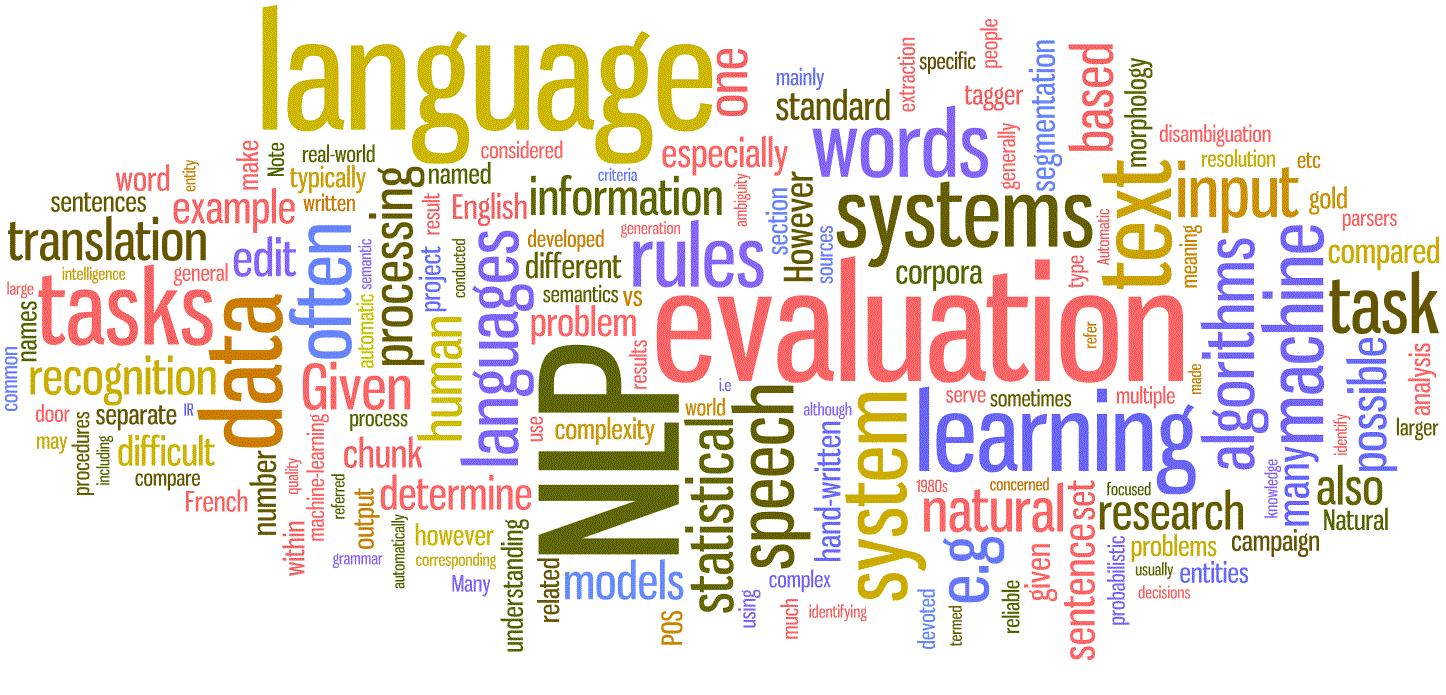

## <b> Problem Description </b>

### In this project your task is to identify major themes/topics across a collection of BBC news articles. You can use clustering algorithms such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) etc.

## <b> Data Description </b>

### The dataset contains a set of news articles for each major segment consisting of business, entertainment, politics, sports and technology. You need to create an aggregate dataset of all the news articles and perform topic modeling on this dataset. Verify whether these topics correspond to the different tags available.

The problem that we would like to talk about here is to find the best segregation of documents according to their topics. This kind of separation can be used for assigning a topic to a document (which is called topic labeling) or for general determination of compressed characteristics of a huge text data set.

# **Mounting Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Importing The Modules**

In [ ]:
import pandas as pd
import numpy as np
import string
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import gensim.corpora as corpora
from collections import Counter
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import spacy
nltk.download('stopwords')
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
pip install autocorrect


     |████████████████████████████████| 624kB 8.1MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.3.0-cp36-none-any.whl size=621588 sha256=df9b5766001395f036960d085689c7357886e637c7e29ca05d386e0ac9af90d0
  Stored in directory: /root/.cache/pip/wheels/cc/1c/30/6b0199afbd20eef5959f5eaa0ead86aeef84391740482b2279
Successfully built autocorrect


In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 7.4MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=6a78739306a0acda4ec32f0c9306e528569c8999ac23bfa362ae494d7fd46bae
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


**First we have to develop our own dataset for our dataset, we will read all the downloaded articles into one list corpus. We will use the folder name as a list of labels.Then we can covert them into dataframe**

In [ ]:
News=[]
Type=[]

path="/content/drive/MyDrive/Almabetter/Cohort Aravali/Module 4/Capstone-4/Topic Modeling on BBC News Articles/bbc"
folders=["business","entertainment","politics","sport","tech"] 
for i in folders:
    files=os.listdir(path+'/'+i)
    for text_file in files:
        file_path=path + '/'+i+'/'+text_file
        with open(file_path,'rb') as f:
            data=f.read()
        News.append(data)
        Type.append(i)
      

data={'news':News,'type':Type}
df = pd.DataFrame(data)

**Basic Operation**

In [ ]:
df.head()

,news,type
0,b'Mixed signals from French economy\n\nThe Fre...,business
1,b'US trade gap hits record in 2004\n\nThe gap ...,business
2,b'Indonesians face fuel price rise\n\nIndonesi...,business
3,b'High fuel prices hit BA\'s profits\n\nBritis...,business
4,b'Sluggish economy hits German jobs\n\nThe num...,business


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    2225 non-null   object
 1   type    2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [ ]:
# removing duplicate observations
df=df.drop_duplicates()

In [ ]:
df.type.value_counts(normalize=True)*100

sport            23.742360
business         23.648331
politics         18.946874
entertainment    17.348378
tech             16.314057
Name: type, dtype: float64

# **Text Preprocessing**

In [ ]:
# Converting column into astring
df['news'] = df['news'].astype('str') 

In [ ]:
# Removing HTML Tag
import re
def remove_html_tags(text):
	html_pattern = r'<.*?>'
	without_html = re.sub(pattern=html_pattern, repl=' ', string=text)
	return without_html

In [ ]:
df['news']=df['news'].apply(remove_html_tags)

In [ ]:
# Removing URLs
def remove_urls(text):
	url_pattern = r'https?://\S+|www\.\S+' 
	without_urls = re.sub(pattern=url_pattern, repl=' ', string=text)
	return without_urls

In [ ]:
df['news']=df['news'].apply(remove_urls)

In [ ]:
# Removing numbers
def remove_numbers(text):
	number_pattern = r'\d+'
	without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
	return without_number

In [ ]:
df['news']=df['news'].apply(remove_numbers)

In [ ]:
# Removing single Charecter
def remove_single_char(text):
	single_char_pattern = r'\s+[a-zA-Z]\s+'
	without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
	return without_sc

In [ ]:
df['news']=df['news'].apply(remove_single_char)

In [ ]:
stop_list=list(stopwords.words('english'))
stop_list.append('would')
stop_list.append('could')
stop_list.append('say')

In [ ]:
# Removing StopWord
def Change_text(msg):
  punc=[char for char in msg if str(char) not in string.punctuation]
  no_punc=''.join(punc)
  main_text=[word for word in no_punc.split() if word.lower() not in stop_list]
  return ' '.join(main_text)

In [ ]:
# Doing Lemmatization
def lemmatization(texts):
  sentence=''
  allowed_postags=['NOUN','ADJ','VERB','ADV']
  texts_out=[]
  doc=nlp(texts)
  texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
  return ' '.join(texts_out[0])

In [ ]:
df['news']=df['news'].apply(Change_text)

In [ ]:
nlp=spacy.load('en',disable=['parser', 'ner'])
df['news']=df['news'].apply(lemmatization)

# **The EDA**

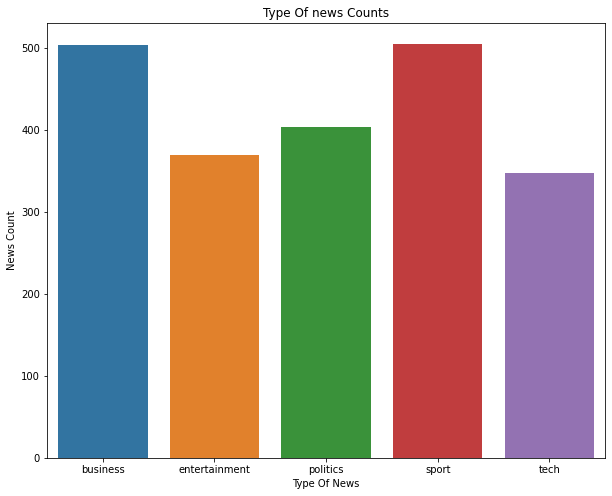

In [ ]:
import warnings 
plt.figure(figsize=(10,8))
warnings.filterwarnings("ignore")
sns.countplot(df['type'], data=df)
plt.xlabel("Type Of News")
plt.ylabel("News Count")
plt.title("Type Of news Counts")
plt.show()

In [ ]:
df['length']=df['news'].apply(len)
df.head()

,news,type,length,word_count
0,french economy pick speed end official figure ...,business,608,94
1,trade gap hit record nnthe gap export import h...,business,983,158
2,bindonesian face fuel price government confirm...,business,830,134
3,bhigh fuel price hit blame high fuel price dro...,business,1121,182
4,bsluggish economy hit german number people wor...,business,1076,155


In [ ]:
df['word_count'] = df['news'].apply(lambda x: len(str(x).split(" ")))
df.head()

,news,type,length,word_count
0,french economy pick speed end official figure ...,business,608,82
1,trade gap hit record nnthe gap export import h...,business,983,146
2,bindonesian face fuel price government confirm...,business,830,123
3,bhigh fuel price hit blame high fuel price dro...,business,1121,159
4,bsluggish economy hit german number people wor...,business,1076,145


In [ ]:
bbc1_business = df[df['type'] == 'business']
bbc1_entertainment = df[df['type'] == 'entertainment']
bbc1_politics = df[df['type'] == 'politics']
bbc1_sport = df[df['type'] == 'sport']
bbc1_tech = df[df['type'] == 'tech']

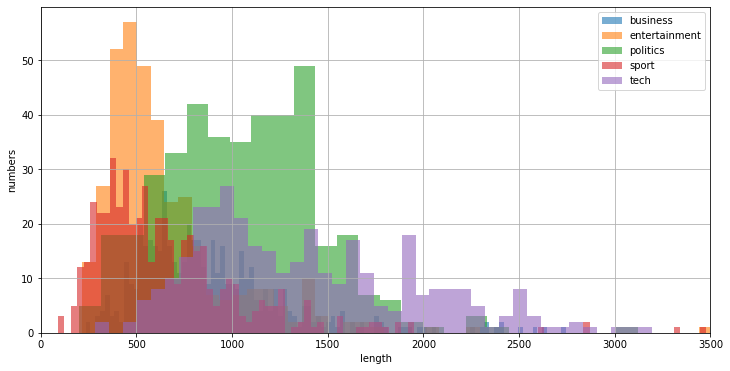

In [ ]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 100
plt.hist(bbc1_business['length'], alpha = 0.6, bins=bins, label='business')
plt.hist(bbc1_entertainment['length'], alpha = 0.6, bins=bins, label='entertainment')
plt.hist(bbc1_politics['length'], alpha = 0.6, bins=bins, label='politics')
plt.hist(bbc1_sport['length'], alpha = 0.6, bins=bins, label='sport')
plt.hist(bbc1_tech['length'], alpha = 0.6, bins=bins, label='tech')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,3500)
plt.grid()
plt.show()

Length of all type of topics are dense between 1500-2000 so couldn't distinguish between topic with help of word length. 

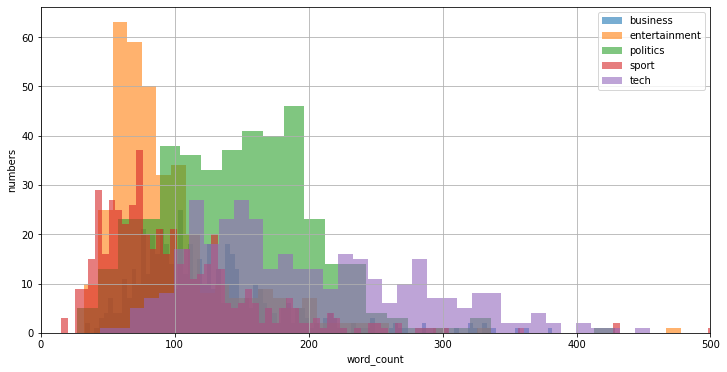

In [ ]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 100
plt.hist(bbc1_business['word_count'], alpha = 0.6, bins=bins, label='business')
plt.hist(bbc1_entertainment['word_count'], alpha = 0.6, bins=bins, label='entertainment')
plt.hist(bbc1_politics['word_count'], alpha = 0.6, bins=bins, label='politics')
plt.hist(bbc1_sport['word_count'], alpha = 0.6, bins=bins, label='sport')
plt.hist(bbc1_tech['word_count'], alpha = 0.6, bins=bins, label='tech')
plt.xlabel('word_count')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,500)
plt.grid()
plt.show()

It's similar to length which is prittey obvious.

## First we develop a list of the top words used across all headlines, giving us a glimpse into the core vocabulary of the source data. Stop words are omitted here to avoid any trivial conjunctions, prepositions, etc.

In [ ]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

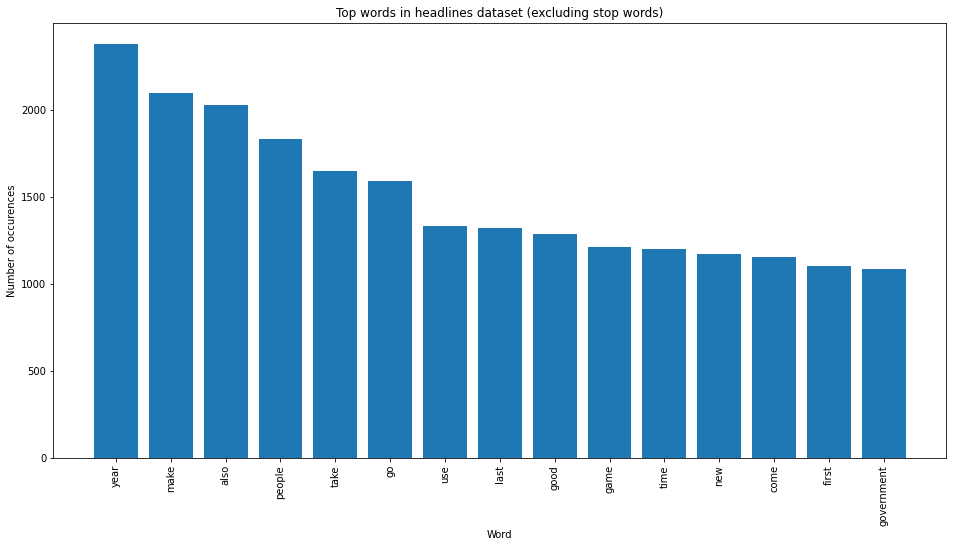

In [ ]:
count_vectorizer = CountVectorizer()
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df['news'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top words in headlines dataset (excluding stop words)')
ax.set_xlabel('Word')
ax.set_ylabel('Number of occurences')
plt.show()

We could see that our top word are in our dataset are year,make

**WordcCloud for Topic Business**

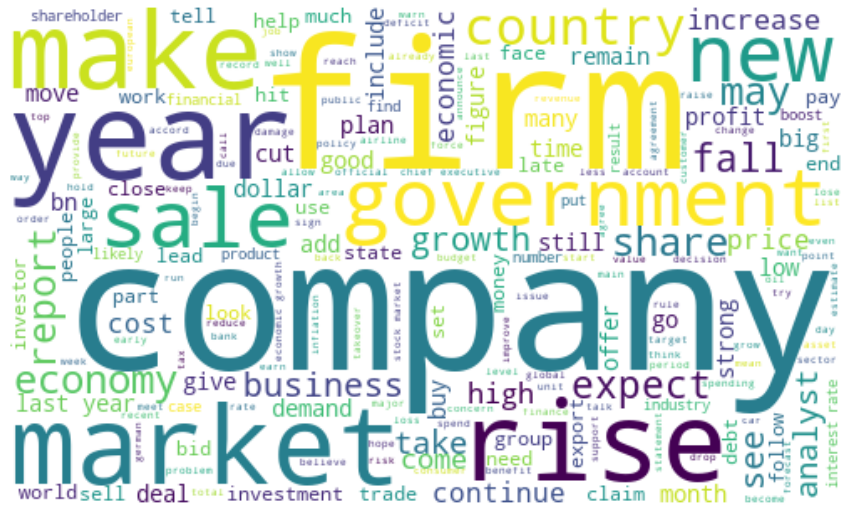

In [ ]:
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='business']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="white", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**WordCloud For Topic Tech**

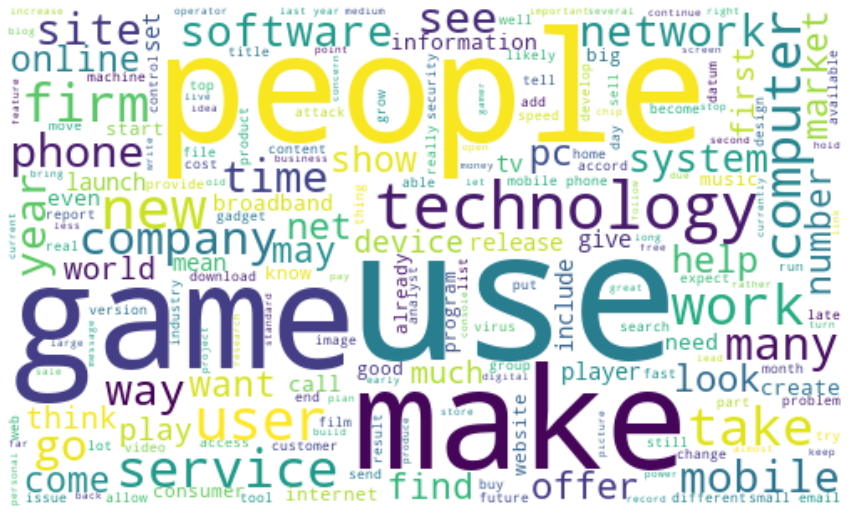

In [ ]:
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='tech']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="white", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

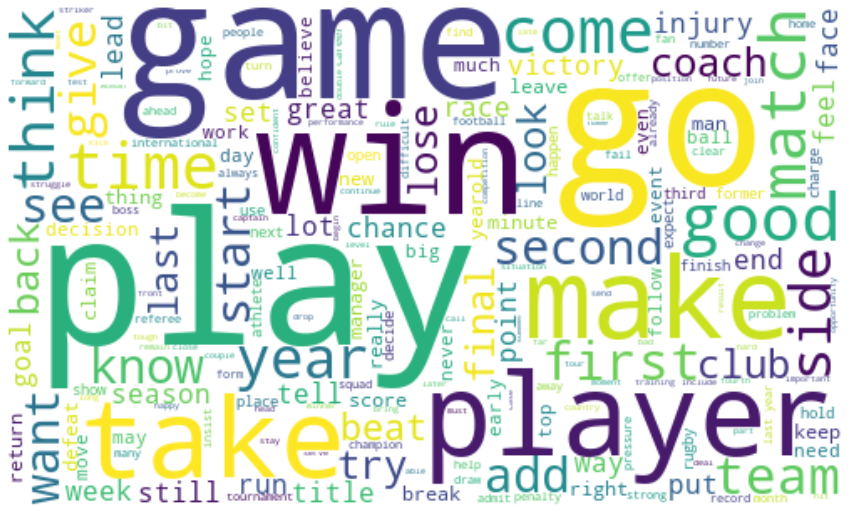

In [ ]:
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='sport']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="white", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# **Topic Modelling**

We now apply a clustering algorithm to the headlines corpus in order to study the topic focus of BBC News. 

TF-IDF Vectorizer with unigram

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.8, max_features=8000,min_df=0.05)

In [ ]:
matrix=vectorizer.fit_transform(df['news'])

In [ ]:
df1 = pd.DataFrame(matrix.todense() , columns=vectorizer.get_feature_names())

In [ ]:
df1.head()

,able,accept,access,accord,account,accuse,act,action,add,admit,affect,age,ago,agree,ahead,aim,allow,almost,already,also,always,amount,analyst,announce,annual,appear,area,argue,ask,attack,attempt,available,average,avoid,award,away,back,bad,base,battle,...,thing,think,third,time,title,together,top,total,tough,trade,trial,try,turn,tv,understand,use,user,value,version,victory,video,view,vote,want,warn,watch,way,website,week,well,whole,win,winner,work,world,write,year,yearold,yet,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.119437,0.0,0.00000,0.0,0.000000,0.057079,0.0,0.0,0.000000,0.0,0.139301,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.087640,0.0,0.0,0.000000,0.137859,0.0,0.0,0.000000,0.000000,0.0,0.055946,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095645,0.0,0.0,0.0,0.000000,0.0,0.07334,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.087455,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.059030,0.0,0.0,0.0,...,0.072576,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.363037,0.0,0.000000,0.074579,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.058792,0.0,0.112502,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.034050,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.077830,0.0,0.000000,0.078671,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.043072,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.060103,0.000000,0.0,0.0,0.048472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098523,0.000000,0.0,0.000000,0.0,0.0,0.051739,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.066747,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.083297,0.0,0.00000,0.0,0.000000,0.039808,0.0,0.0,0.162065,0.0,0.097150,0.0,0.0,0.000000,0.0,0.088399,0.000000,0.0,0.100431,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.075774,0.000000,0.0,0.0,0.000000,0.091479,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.084634,0.0,0.061121,0.0,0.0,0.060490,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.156070,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.104802,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.074376,0.041923,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.064681,0.0,0.0,0.0,...,0.000000,0.0,0.079800,0.000000,0.0,0.0,0.149207,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.122675,0.000000,0.0,0.041091,0.0,0.0,0.0


# **Latent Semantic Analysis**

In [ ]:
lsa_model = TruncatedSVD(n_components=5)
lsa_topic_matrix = lsa_model.fit_transform(matrix)

In [ ]:
lsa_topic_dist = pd.DataFrame(lsa_model.transform(matrix))
lsa_topic_dist.to_csv('lsa.csv', index=False)
lsa_doc=pd.read_csv("lsa.csv")

In [ ]:
lsa_doc.columns=['topic1','topic2','topic3','topic4','topic5']

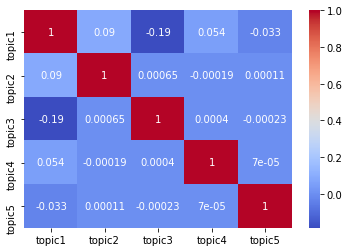

In [ ]:
sns.heatmap(data=lsa_doc.corr(),annot=True,cmap='coolwarm')

In [ ]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [ ]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

However, these topic categories are in and of themselves a little meaningless. In order to better characterise them, it will be helpful to find the most frequent words in each.

In [ ]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(lsa_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0],end=" ")
        

Topic 0: 
year make game also people go take Topic 1: 
game film play win good player award Topic 2: 
film award star director include movie good Topic 3: 
use phone mobile technology user people computer Topic 4: 
sale game market price rise growth fall 

Thus we have converted our initial small sample of headlines into a list of predicted topic categories, where each category is characterised by its most frequent words. The relative magnitudes of each of these categories can then be easily visualised though use of a bar chart.

In [ ]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(5):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [ ]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2225 samples in 0.007s...
[t-SNE] Computed neighbors for 2225 samples in 0.102s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2225
[t-SNE] Computed conditional probabilities for sample 2000 / 2225
[t-SNE] Computed conditional probabilities for sample 2225 / 2225
[t-SNE] Mean sigma: 0.055558
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.018196
[t-SNE] KL divergence after 2000 iterations: 0.806176


Now that we have reduced these n_topics-dimensional vectors to two-dimensional representations, we can then plot the clusters using Bokeh. Before doing so however, it will be useful to derive the centroid location of each topic, so as to better contextualise our visualisation.

In [ ]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:5]

In [ ]:
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(5):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [ ]:
df['target'] = pd.factorize(df['type'])[0] + 1

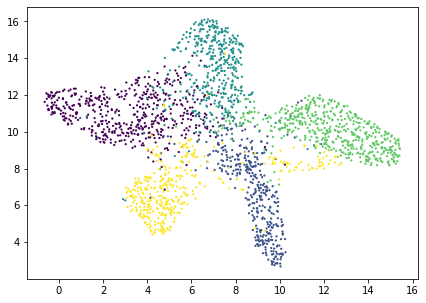

In [ ]:
import umap

X_topics = lsa_model.fit_transform(matrix)
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], c = df.target,s = 5,edgecolor='none')
plt.show()


In [ ]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, matrix, vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(5), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(5):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

# **Latent Dirichilet Allocation(Using Gensim)**

In [ ]:
word_data=df['news'].str.split().tolist()

In [ ]:
id2word=corpora.Dictionary(word_data)
corpus=[id2word.doc2bow(text) for text in word_data]

In [ ]:
print(corpus[:120])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 4), (25, 1), (26, 2), (27, 3), (28, 3), (29, 1), (30, 2), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 2), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 2), (61, 3), (62, 2), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 2), (70, 1), (71, 1), (72, 1), (73, 1)], [(11, 1), (13, 2), (14, 2), (15, 1), (21, 2), (26, 1), (28, 2), (31, 2), (54, 3), (69, 1), (73, 3), (74, 1), (75, 1), (76, 2), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 2), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 5), (98, 2), (99, 1), (100, 2

In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('10n', 1),
  ('activity', 1),
  ('ahead', 1),
  ('also', 1),
  ('annual', 1),
  ('apparent', 1),
  ('best', 1),
  ('bmixe', 1),
  ('body', 1),
  ('confirm', 1),
  ('continuation', 1),
  ('continue', 1),
  ('early', 1),
  ('economic', 1),
  ('economist', 1),
  ('economy', 2),
  ('economynnthe', 1),
  ('end', 1),
  ('estimate', 1),
  ('eurozone', 1),
  ('fall', 1),
  ('figure', 2),
  ('flash', 1),
  ('forecast', 1),
  ('french', 4),
  ('full', 1),
  ('good', 2),
  ('government', 3),
  ('growth', 3),
  ('health', 1),
  ('high', 2),
  ('hit', 1),
  ('hopesnnaccorde', 1),
  ('improve', 2),
  ('indicator', 1),
  ('industrial', 1),
  ('leave', 1),
  ('look', 1),
  ('make', 1),
  ('mark', 1),
  ('month', 1),
  ('noise', 1),
  ('number', 1),
  ('official', 1),
  ('open', 1),
  ('output', 2),
  ('pick', 1),
  ('positive', 2),
  ('predictednndespite', 1),
  ('quarterly', 2),
  ('rebound', 1),
  ('reiterate', 1),
  ('release', 1),
  ('remain', 1),
  ('say', 1),
  ('seasonallyadjuste', 1),
  ('s

In [ ]:
import gensim

In [ ]:
lda_model= gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=5,update_every=1)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [ ]:
import pyLDAvis.gensim

In [ ]:
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(lda_model,corpus,id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.044885  0.014791       1        1  49.117597
3     -0.048015 -0.000937       2        1  17.134225
4      0.031603 -0.031729       3        1  13.391324
0      0.016566 -0.029185       4        1  10.309068
2      0.044731  0.047061       5        1  10.047786, topic_info=         Term         Freq        Total Category  logprob  loglift
54        say  7284.000000  7284.000000  Default  30.0000  30.0000
588     phone  1133.000000  1133.000000  Default  29.0000  29.0000
239       use  2308.000000  2308.000000  Default  28.0000  28.0000
213    people  2313.000000  2313.000000  Default  27.0000  27.0000
1212     game  1720.000000  1720.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
324      take   132.628398  1258.046128   Topic5  -5.5713   0.0481
139       new   133.068355  1546.591671   Topic5  -5.5680  -0.1551
399      work   116.987969  1002.390203   Topic5  -5.6968   0.1497
1584  website   104.384605   502.249707   Topic5  -5.8108   0.7268
1212     game   112.421649  1720.367247   Topic5  -5.7366  -0.4302

[450 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
17284      1  0.990101   16k
15757      1  0.984964  23rd
17285      1  0.987682  42nd
17286      1  0.989497  59th
9454       1  0.184599   70p
...      ...       ...   ...
73         1  0.509491  year
73         2  0.135864  year
73         3  0.156682  year
73         4  0.098063  year
73         5  0.100255  year

[1227 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 5, 1, 3])

# **Latent Dirichilet Allocation**

In [ ]:
model=LatentDirichletAllocation(n_components=5)
lda_topic_matrix=model.fit_transform(matrix)

In [ ]:
doc_topic_dist = pd.DataFrame(model.transform(matrix))
doc_topic_dist.to_csv('doc_topic_dist.csv', index=False)
doc=pd.read_csv("doc_topic_dist.csv")

In [ ]:
doc.columns=['topic1','topic2','topic3','topic4','topic5']

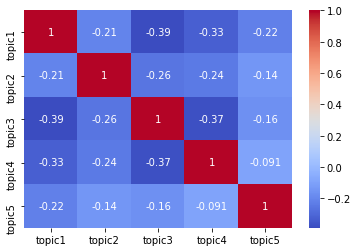

In [ ]:
sns.heatmap(data=doc.corr(),annot=True,cmap='coolwarm')

In [ ]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [ ]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2225 samples in 0.002s...
[t-SNE] Computed neighbors for 2225 samples in 0.086s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2225
[t-SNE] Computed conditional probabilities for sample 2000 / 2225
[t-SNE] Computed conditional probabilities for sample 2225 / 2225
[t-SNE] Mean sigma: 0.004728
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.149910
[t-SNE] KL divergence after 2000 iterations: 0.214489


In [ ]:
top_3_words_lda = get_top_n_words(3, lda_keys, matrix,vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(5), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(5):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

In [ ]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

In [ ]:
lda_panel = pyLDAvis.sklearn.prepare(model,matrix,vectorizer,mds='tsne')
lda_panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      150.222153  -72.269554       1        1  25.548742
4       51.163364 -159.968018       2        1  21.924822
0      -73.144554   21.523815       3        1  20.795086
2      -66.410133 -110.606438       4        1  18.101271
3       54.417324   12.443444       5        1  13.630079, topic_info=      Term       Freq      Total Category  logprob  loglift
157   film  79.000000  79.000000  Default  30.0000  30.0000
34   award  42.000000  42.000000  Default  29.0000  29.0000
421   star  46.000000  46.000000  Default  28.0000  28.0000
176   game  80.000000  80.000000  Default  27.0000  27.0000
287  music  44.000000  44.000000  Default  26.0000  26.0000
..     ...        ...        ...      ...      ...      ...
437   take  16.018057  78.237016   Topic5  -4.7205   0.4069
162  first  14.932085  66.410394   Topic5  -4.7907   0.5005
231   last  12.437678  71.041527   Topic5  -4.9734   0.2504
182     go  12.468284  76.617354   Topic5  -4.9710   0.1773
260   make  12.631378  87.991918   Topic5  -4.9580   0.0518

[249 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2         1  0.206792  access
2         2  0.103396  access
2         4  0.672072  access
5         1  0.831822  accuse
5         2  0.110910  accuse
...     ...       ...     ...
483       1  0.155648    year
483       2  0.340481    year
483       3  0.175104    year
483       4  0.097280    year
483       5  0.233473    year

[770 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 3, 4])

###This is a much better result! Controlling for  t -SNE, it would seem that LDA has had much more succcess than LSA and LDA(Genisim) in separating out the topic categories. For this reason, LDA appears the more appropriate algorithm when we Use bigram for our data.

# **Latent Dirichilet Allocation(With Count Vectorizer and Bigram)**

In [ ]:
bivectorizer = CountVectorizer(min_df=10, max_df=0.9, ngram_range=(2,2))
bigram_vectorized = bivectorizer.fit_transform(df['news'])
df2= pd.DataFrame(bigram_vectorized.todense() , columns=bivectorizer.get_feature_names())

In [ ]:
df2.head()

,accord analyst,accord figure,accord report,accord research,action take,actor award,add government,add say,add think,affair spokesman,agency report,ago say,agree pay,allow people,almost year,already make,already say,also announce,also appear,also back,also believe,also call,also expect,also face,also feature,also find,also give,also good,also help,also include,also increase,also look,also make,also mean,also need,also offer,also plan,also play,also provide,also reveal,...,world big,world champion,world large,world lead,world number,world poor,world record,world say,year accord,year add,year ago,year also,year award,year big,year come,year company,year earlier,year early,year event,year first,year go,year good,year however,year include,year last,year later,year low,year make,year old,year say,year see,year take,year tell,year think,year time,year top,year work,year year,young people,young player
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
bi_lda = LatentDirichletAllocation(n_components=5, max_iter=10, learning_method='online',verbose=True)
data_bi_lda = bi_lda.fit_transform(bigram_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [ ]:
bigram = pd.DataFrame(bi_lda.transform(bigram_vectorized))
bigram.to_csv('bigram.csv', index=False)
doc=pd.read_csv("bigram.csv")

In [ ]:
doc.columns=['topic1','topic2','topic3','topic4','topic5']

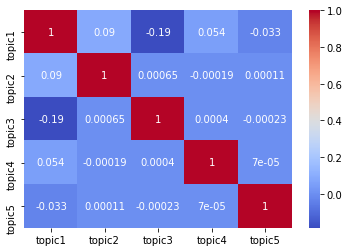

In [ ]:
sns.heatmap(data=lsa_doc.corr(),annot=True,cmap='coolwarm')

In [ ]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

In [ ]:
bi_dash = pyLDAvis.sklearn.prepare(bi_lda, bigram_vectorized, bivectorizer, mds='tsne')
bi_dash

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      150.222153  -72.269554       1        1  24.734267
2       51.163364 -159.968018       2        1  21.527665
4      -73.144554   21.523815       3        1  20.947871
1      -66.410133 -110.606438       4        1  20.011720
0       54.417324   12.443444       5        1  12.778477, topic_info=                  Term        Freq       Total Category  logprob  loglift
968     prime minister  308.000000  308.000000  Default  30.0000  30.0000
748       mobile phone  183.000000  183.000000  Default  29.0000  29.0000
1106        six nation  164.000000  164.000000  Default  28.0000  28.0000
1230        tony blair  180.000000  180.000000  Default  27.0000  27.0000
420   general election  172.000000  172.000000  Default  26.0000  26.0000
...                ...         ...         ...      ...      ...      ...
735     million people   26.054931   64.524794   Topic5  -5.0039   1.1506
1169        take place   25.964975   95.134417   Topic5  -5.0073   0.7589
339      film festival   21.286460   35.231385   Topic5  -5.2060   1.5535
827         number one   23.326391  132.477343   Topic5  -5.1145   0.3206
910        people want   20.946817   41.164428   Topic5  -5.2221   1.3818

[251 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
20        3  0.957980    alex ferguson
22        3  0.968313     allow people
30        5  0.961254  analyst jupiter
33        2  0.962867    andy robinson
39        3  0.958851   antivirus firm
...     ...       ...              ...
1351      2  0.976129     world record
1352      3  0.965589    world service
1353      5  0.979397       world tour
1358      1  0.227478     young people
1358      3  0.758260     young people

[320 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 5, 2, 1])

We could see our cluster can clearly distinguisheable and we could evaluate them by observation.

ex- Cluster contain general election , Tony blair so we could conclude it's belongs to politics.


# **Word2vec**

In [ ]:
df.head()

,news,type,length,target
0,bmixe signal french economynnthe french econom...,business,701,1
1,gap hit record gap export import hit late figu...,business,1082,1
2,bindonesian face fuel price government confirm...,business,893,1
3,bhigh fuel price hit ba profitsnnbritish blame...,business,1307,1
4,bsluggish economy hit german number people wor...,business,1140,1


In [ ]:
from gensim.models import Word2Vec
word2vec = Word2Vec(word_data, min_count=2)

In [ ]:
vocabulary = word2vec.wv.vocab
print(vocabulary)

{'bmixe': <gensim.models.keyedvectors.Vocab object at 0x7fc82c3fea90>, 'signal': <gensim.models.keyedvectors.Vocab object at 0x7fc82c3fe860>, 'french': <gensim.models.keyedvectors.Vocab object at 0x7fc82c3fe5f8>, 'economy': <gensim.models.keyedvectors.Vocab object at 0x7fc82c400c50>, 'pick': <gensim.models.keyedvectors.Vocab object at 0x7fc82c400400>, 'speed': <gensim.models.keyedvectors.Vocab object at 0x7fc82c400588>, 'end': <gensim.models.keyedvectors.Vocab object at 0x7fc82c400160>, 'official': <gensim.models.keyedvectors.Vocab object at 0x7fc82c400f98>, 'figure': <gensim.models.keyedvectors.Vocab object at 0x7fc82c400cf8>, 'show': <gensim.models.keyedvectors.Vocab object at 0x7fc82c400208>, 'still': <gensim.models.keyedvectors.Vocab object at 0x7fc82c400e80>, 'look': <gensim.models.keyedvectors.Vocab object at 0x7fc82c4005c0>, 'set': <gensim.models.keyedvectors.Vocab object at 0x7fc82c400a58>, 'fall': <gensim.models.keyedvectors.Vocab object at 0x7fc82c400668>, 'short': <gensim.mo

In [ ]:
sim_words = word2vec.wv.most_similar('tax')
for x in sim_words:
  print(x)

('cut', 0.9972347617149353)
('income', 0.9893519878387451)
('cost', 0.9890127182006836)
('broadband', 0.9883041381835938)
('spending', 0.9875277280807495)
('premium', 0.9868553876876831)
('taxis', 0.9863653182983398)
('speed', 0.9850698113441467)
('council', 0.985069751739502)
('raise', 0.9850683212280273)


In [ ]:
word=pd.DataFrame(sim_words)
word.head()

,0,1
0,cut,0.997235
1,income,0.989352
2,cost,0.989013
3,broadband,0.988304
4,spending,0.987528


# **Conclusion**

In  this work  we have taken  BBC news  dataset for analyzingthe   news   topics.   We   applied   various   machine   learning topicmodeling   approaches   (Latent   Dirichlet  Allocation   (LDA) Latent   Semantic  Analysis   (LSA).   

From   the   comparative analysis made, it  has   been   observed   that   the topic   modeling approaches  find  the   hidden  topics  and relationship  betweenwords  and documents  with multiple  probability distributions.As a future work, using one of the topic modeling algorithms, we can implement various applications for  recommending research  articles, analyzing news articles   etc,  which can   be used for segregation of documents from top